In [1]:
from __future__ import print_function, division

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import time
import os
import copy

from util import *

plt.ion()

In [2]:
image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=image_mean,
                                     std=image_std)
data_transforms = {
    TRAIN : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    VAL : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        normalize
    ]),
    TEST : transforms.Compose([
    transforms.Resize(image_size, image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    normalize
    ]),
}


In [3]:
train_dataset = ImageFolder(root=train_dir,
                           transform = data_transforms[TRAIN])
train_loader = DataLoader(train_dataset, 
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers = num_workers)

val_dataset = ImageFolder(root=val_dir,
                           transform = data_transforms[VAL])
val_loader = DataLoader(val_dataset, 
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers = num_workers)

test_dataset = ImageFolder(root=test_dir,
                           transform = data_transforms[TEST])
test_loader = DataLoader(test_dataset, 
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers = num_workers)

class_names = train_dataset.classes

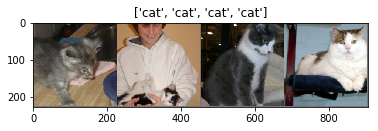

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(image_mean)
    std = np.array(image_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.imsave("final_data_augmentation.png", inp)


# Get a batch of training data
batch_to_view = next(iter(train_loader))
inputs, classes = batch_to_view[0][:4], batch_to_view[1][:4]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def get_model(model_name=RESNET50, use_cuda=True):
    model = None
    if(model_name==RESNET50):
        model = models.resnet50(pretrained=True)
        model.fc = torch.nn.Linear(in_features=2048, out_features=2)
    if(model_name==RESNET101):
        model = models.resnet101(pretrained=True)
        model.fc = torch.nn.Linear(in_features=2048, out_features=2)
    if(use_cuda):
        return model.cuda()
    else:
        return model.cuda()

def get_loss_fn(use_cuda=True):
    if(use_cuda):
        return torch.nn.CrossEntropyLoss().cuda()
    else:
        return torch.nn.CrossEntropyLoss()

def get_optimizer(model, learning_rate):
    return torch.optim.Adam(
        model.fc.parameters(), learning_rate
    )

def get_lr_scheduler(optimizer, step_size = 30, gamma=0.1):
    return torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)

def persist_model(model_state, save_path):
    torch.save(model_state, save_path)


In [6]:
class ModelMetric():
    '''class to track the avergae accuracy for the model with different datasets
    '''
    
    def __init__(self):
        self.correct_count = 0.0
        self.total_count = 0.0
        self.total_loss = 0.0
    
    def update(self, correct_count, count, loss):
        self.correct_count+=correct_count
        self.total_count+=count
        self.total_loss+=loss*count
    
    @property
    def accuracy(self):
        return self.correct_count/self.total_count
    
    @property
    def average_loss(self):
        return self.total_loss/self.total_count

In [7]:
def compute_accuracy(y_pred, labels):
    """Computes the number of correct matches in y_pred"""
    _, predictions = y_pred.topk(k = 1, dim=1)
    batch_size = labels.size(0)
    correct_count = torch.sum(predictions.eq(labels.view(-1, 1).expand_as(predictions)))
    if(use_cuda):
        correct_count = correct_count.cpu().data.numpy()[0]
    else:
        correct_count = correct_count.data.numpy()[0]
    total_count = labels.shape[0]
    return (correct_count, total_count)

In [8]:
def val(model, val_loader, loss_fn, metric):
    
    model.eval()
    start_time = time.time()
    
    for (images, labels) in val_loader:
        images = torch.autograd.Variable(images, volatile=True)
        labels = torch.autograd.Variable(labels, volatile=True)
        if(use_cuda):
            images = images.cuda()
            labels = labels.cuda()
        
        predictions = model(images)
        predictions_loss = loss_fn(predictions, labels)
        num_correct_predictions, num_total_predictions = compute_accuracy(predictions, labels)
        metric.update(num_correct_predictions, num_total_predictions, predictions_loss)
        
    print("Validation Accuracy = {}\n, Validation Loss = {}\n, Time Taken = {} seconds".format(
        metric.accuracy,
        metric.average_loss,
        time.time() - start_time
    ))
    return metric

In [9]:
def train(model, train_loader, loss_fn, optimizer, metric = None):
    running_loss = 0
    
    model.train()
    
    start_time = time.time()
    
    for (images, labels) in train_loader:
        images = torch.autograd.Variable(images)
        labels = torch.autograd.Variable(labels)
        if(use_cuda):
            images = images.cuda()
            labels = labels.cuda()
            
        predictions = model(images)
        predictions_loss = loss_fn(predictions, labels)
        num_correct_predictions, num_total_predictions = compute_accuracy(predictions, labels)
        metric.update(num_correct_predictions, num_total_predictions, predictions_loss)
        optimizer.zero_grad()
        predictions_loss.backward()
        optimizer.step()
        running_loss += predictions_loss.data[0]
        
    print("Training Accuracy = {}\n, Training Loss = {}\n, Time Taken = {} seconds".format(
        train_metric.accuracy,
        train_metric.average_loss,
        time.time() - start_time
    ))
    print(running_loss)
    return metric

In [10]:
model = get_model(model_name=model_name, 
                 use_cuda=use_cuda)
loss_fn = get_loss_fn(use_cuda=use_cuda)
optimizer = get_optimizer(model=model, 
                          learning_rate=learning_rate)
lr_scheduler = get_lr_scheduler(optimizer=optimizer)

In [11]:
best_val_loss = 1e6
train_metric = ModelMetric()
val_metric = ModelMetric()
running_loss = 0
early_stopping_counter = 0
for epoch in range(num_epochs):
    train_metric = train(model = model,
         train_loader = train_loader,
         loss_fn = loss_fn, 
         optimizer = optimizer,
         metric = train_metric)
    
    val_metric = val(model = model,
                          val_loader = val_loader,
                          loss_fn = loss_fn,
                        metric = val_metric)
    val_accuracy = val_metric.accuracy
    val_loss = val_metric.average_loss
    if(val_loss.data.cpu().numpy()[0] < best_val_loss):
        best_val_loss = val_loss
        model_state = {
            EPOCH: epoch+1,
            STATE_DICT: model.state_dict(),
            VAL_ACCURACY: val_accuracy,
            VAL_LOSS: val_loss
        }
        save_path = "/u/sodhanis/projects/DogsVsCats/model/checkpoint_epoch_"\
        +str(epoch)+"_val_accuracy_"+str(int(val_accuracy*1e4))+"_val_loss_"+str(int(val_loss*1e4))+".path.tar"
        persist_model(model_state=model_state,
                     save_path = save_path)
        early_stopping_counter = 0
    else:
        early_stopping_counter+=1
        if(early_stopping_counter == early_stopping_criteria):
            break

Training Accuracy = 0.9349268292682927
, Training Loss = Variable containing:
 0.1624
[torch.cuda.FloatTensor of size 1 (GPU 0)]

, Time Taken = 347.77491760253906 seconds
104.0193645581603
Validation Accuracy = 0.9744
, Validation Loss = Variable containing:
1.00000e-02 *
  7.2802
[torch.cuda.FloatTensor of size 1 (GPU 0)]

, Time Taken = 26.04322910308838 seconds


In [12]:
# val_metric.accuracy

0.97440000000000004

In [13]:
checkpoint = torch.load("model/checkpoint_epoch_0_val_accuracy_0_val_loss_0.path.tar")
model.load_state_dict(checkpoint['state_dict'])

In [14]:
def visualize_model(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    for (i, (images, labels)) in enumerate(val_loader):
        images = torch.autograd.Variable(images)
        labels = torch.autograd.Variable(labels)
        if(use_cuda):
            images = images.cuda()
            labels = labels.cuda()

        outputs = model(images)
        _, preds = torch.max(outputs.data, 1)

        for j in range(images.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(images.cpu().data[j])

            if images_so_far == num_images:
                model.train(mode=was_training)
                return
    model.train(mode=was_training)

In [15]:
model_parameters = model.parameters()
params = sum([np.prod(p.size()) for p in model_parameters])
print("Total number of parameters in {} model = {}".format(model_name, params))

model_parameters = model.fc.parameters()
params = sum([np.prod(p.size()) for p in model_parameters])
print("Total number of trainable parameters in the finetuned {} model = {}".format(model_name, params))

Total number of parameters in resnet101 model = 42504258
Total number of trainable parameters in the finetuned resnet101 model = 4098


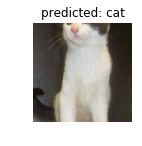

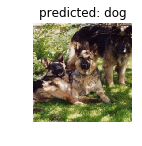

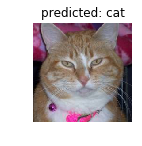

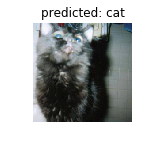

In [16]:
# visualize_model(model, num_images=4)